<a href="https://colab.research.google.com/github/DeeptiHari21/Projects/blob/Master/LinkedIn_JobsData_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv("linkdin_Job_data.csv")
df.shape

(7927, 16)

# Cleaning

Basic cleaning - removing unnecessary columns

In [ ]:
# drop 'column1' column
df = df.drop(columns='Column1')

# drop rows where 'job' is nan
df = df[~df["job"].isna()]

df.shape

(7894, 15)

In [ ]:
# drop job_ID column - these are unique values which won't help analysis
# drop company_id column - many rows are empty here, and we can't use company id for analysis
# drop alumni column - this data is random, and specific to the person who scrapped the data
# drop Hiring_person and hiring_person_link column - we don't need the link
df.drop(columns=['job_ID', 'company_id', 'alumni', 'Hiring_person', 'hiring_person_link'], inplace=True)

## Seniority

Get the **seniority** of the position

In [ ]:
# separate full_time_remote column - some of them have the seniority of the position

split = df["full_time_remote"].str.split(" · ", n=1, expand=True) # make a new dataframe with the two split columns

df["full_part_time"] = split[0] # take the full-time/remote column
df["seniority"] = split[1] # take the position

df = df.drop(columns='full_time_remote')

In [ ]:
# where position is not given, but job description contains senior/sr, make seniority senior
df.loc[df['seniority'].isna() & df['job'].str.lower().str.contains('senior')  | df['job'].str.lower().str.contains('lead') | df['job'].str.lower().str.contains('sr.') | df['job'].str.lower().str.contains('sr '), 'seniority'] = 'Senior'

# where 'job' contains manager, make seniority senior
df.loc[df['seniority'].isna() & df['job'].str.lower().str.contains('manager'), 'seniority'] = 'Senior'

# where position is not specified anywhere, make it junior
# here I assume that 'junior' is between 'associate' and 'mid-senior level'
df.loc[df['seniority'].isna(), 'seniority'] = 'Mid level'

df['seniority'].value_counts()

Mid-Senior level    2866
Mid level           2476
Senior              1676
Associate            597
Entry level          191
Executive             49
Director              29
Internship            10
Name: seniority, dtype: int64

In [ ]:
# assign ranks to the seniority
df.loc[df['seniority']=='Internship', 'seniority_rank'] = 0
df.loc[df['seniority']=='Entry level', 'seniority_rank'] = 1
df.loc[df['seniority']=='Associate', 'seniority_rank'] = 2
df.loc[df['seniority']=='Mid level', 'seniority_rank'] = 3
df.loc[df['seniority']=='Mid-Senior level', 'seniority_rank'] = 4
df.loc[df['seniority']=='Senior', 'seniority_rank'] = 5
df.loc[df['seniority']=='Executive', 'seniority_rank'] = 6
df.loc[df['seniority']=='Director', 'seniority_rank'] = 7

## Locations

Clean up the **locations**

In [ ]:
# separate city/state/country into new columns

split = df['location'].str.split(", ", expand=True)

df['city'] = split[0] # take the city column
df['state'] = split[1] # take the state column
df['country'] = split[2] # take the country column

df = df.drop(columns='location') # drop the original location column

In [ ]:
# clean up city names

df.loc[df['city'].str.lower().str.contains('benga') | df['city'].str.lower().str.contains('banga'), 'city'] = 'Bengaluru'
df.loc[df['city'].str.lower().str.contains('delhi'), 'city'] = 'Delhi'
df.loc[df['city'].str.lower().str.contains('chennai') | df['city'].str.lower().str.contains('madras'), 'city'] = 'Chennai'
df.loc[df['city'].str.lower().str.contains('kolkata'), 'city'] = 'Kolkata'
df.loc[df['city'].str.lower().str.contains('mumbai') | df['city'].str.lower().str.contains('bombay'), 'city'] = 'Mumbai'
df.loc[df['city'].str.lower().str.contains('hyder'), 'city'] = 'Hyderabad'
df.loc[df['city'].str.lower().str.contains('guru') | df['city'].str.lower().str.contains('gurg'), 'city'] = 'Gurgaon'
df.loc[df['city'].str.lower().str.contains('ahmeda'), 'city'] = 'Ahmedabad'
df.loc[df['city'].str.lower().str.contains('pune') | df['city'].str.lower().str.contains('puna'), 'city'] = 'Pune'
df.loc[df['city'].str.lower().str.contains('coimba'), 'city'] = 'Coimbatore'
df.loc[df['city'].str.lower().str.contains('visha') | df['city'].str.lower().str.contains('visa'), 'city'] = 'Vishakhapatnam'

# if state is Delhi, make all the cities Delhi as well
df.loc[df['state']=='Delhi', 'city'] = 'Delhi'

In [ ]:
# grade the cities by popularity
df.loc[df['city']=='Bengaluru', 'city_popularity'] = 1
df.loc[df['city']=='Delhi', 'city_popularity'] = 2
df.loc[df['city']=='Hyderabad', 'city_popularity'] = 3
df.loc[df['city']=='Mumbai', 'city_popularity'] = 4
df.loc[df['city']=='Gurgaon', 'city_popularity'] = 5
df.loc[df['city']=='Chennai', 'city_popularity'] = 6
df.loc[df['city']=='Pune', 'city_popularity'] = 7
df.loc[df['city']=='Noida', 'city_popularity'] = 8
df.loc[df['city_popularity'].isna(), 'city_popularity'] = 9

In [ ]:
# what ever extra cities are there (nan rows), make it 'others'
df.loc[df['city_popularity']==9, 'city'] = 'Others'

In [ ]:
# drop the state and country columns
df = df.drop(columns=['state','country'])

## Company size

Get the **size** and sector of the company

In [ ]:
# clean the no_of_employ column to get the relative size of the company
split = df['no_of_employ'].str.split(' · ', n=1, expand=True)

# take the first column with the range of employees
df['company_size'] = split[0]
# take the second column to get the sector
df['company_sector'] = split[1]
# remove the original column
df.drop(columns='no_of_employ', inplace=True)

# remove the word 'employees' from the new column
df['company_size'] = df['company_size'].str.split(' ', n=1, expand=True)[0]

# replace nan with unknown
#df['company_size'] = df['company_size'].fillna('unknown')

# split the company size column at -/+ and take just the first part
df['company_size'] = df['company_size'].str.split('-', n=1, expand=True)[0]
df['company_size'] = df['company_size'].str.split('+', n=1, expand=True)[0]

In [ ]:
# rank the company size
df.loc[df['company_size']=='unknown', 'size_rank'] = 0
df.loc[df['company_size']=='1', 'size_rank'] = 1
df.loc[df['company_size']=='11', 'size_rank'] = 2
df.loc[df['company_size']=='51', 'size_rank'] = 3
df.loc[df['company_size']=='201', 'size_rank'] = 4
df.loc[df['company_size']=='501', 'size_rank'] = 5
df.loc[df['company_size']=='1,001', 'size_rank'] = 6
df.loc[df['company_size']=='5,001', 'size_rank'] = 7
df.loc[df['company_size']=='10,001', 'size_rank'] = 8

## Linkedin followers

Clean up the **linkedin_followers** column


In [ ]:
# remove the word 'followers' from the column to keep just the number

# replace the nan with 0
#df['linkedin_followers'] = df['linkedin_followers'].fillna('0')
# replace 'SHREWSBURY', 'WARWICKSHIRE' and other such words with 0
df.loc[~df['linkedin_followers'].str.contains('followers', na=False), 'linkedin_followers'] = np.nan

# split the rows with space delimiter and take just the first part to remove 'followers'
df['linkedin_followers'] = df['linkedin_followers'].str.split(' ', n=1, expand=True)[0]

# remove the commas and change the column to int type
df['linkedin_followers'] = df['linkedin_followers'].str.replace(',', '')
df['linkedin_followers'] = df['linkedin_followers'].astype(float)

## Number of applicants

Clean **no_of_application** column

In [ ]:
# where ever the no_of_application is not a number, make it NaN
df.loc[~df['no_of_application'].isna() & df['no_of_application'].str.isalpha(), 'no_of_application'] = np.nan

# change the column to int type
df['no_of_application'] = df['no_of_application'].astype(float)

## Posted days ago

Clean **posted_day_ago** column

In [ ]:
# separate the "unit" (day/hour/week/minute/second) into a separate column
df['posted_day_ago_unit'] = df['posted_day_ago'].str.split(' ', n=1, expand=True)[1].astype(str)
df['posted_day_ago'] = df['posted_day_ago'].str.split(' ', n=1, expand=True)[0].astype(float)

In [ ]:
# convert all the entries in unit of 'day'

# define a function to do this operation
def convert_to_day(row1, row2):
  """ Function that converts all the posted_day_ago column entries to units of 'day'. It has entries in seconds/minutes/hours/weeks. """
  # multiply by 7 where ever it is in weeks
  if 'week' in row2:
    row1 = row1 * 7
  # divide by 24 where it is in hours
  elif 'hour' in row2:
    row1 = row1 / 24
  # divide by 24*60 where ever it is in minutes
  elif 'minute' in row2:
    row1 = row1 / (24*60)
  # divide by 24*60*60 where ever it is in seconds
  elif 'second' in row2:
    row1 = row1 / (24*60*60)
  else:
    pass
  return row1
# apply the function to the dataframe
#df['posted_day_ago'] = df[['posted_day_ago','posted_day_ago_unit']].apply(convert_to_day)
df['posted_day_ago'] = df.apply(lambda x: convert_to_day(x['posted_day_ago'], x['posted_day_ago_unit']), axis=1)

In [ ]:
# drop the posted_day_ago_unit column
df.drop(columns='posted_day_ago_unit', inplace=True)

## Job details

Clean up **job_details** column

In [ ]:
# remove 'About the job'
df['job_details'] = df['job_details'].str.replace('About the job ', '')

## Work type

Clean up nan values in work_type column

In [ ]:
df['work_type'].value_counts()

On-site    3258
Remote     2999
Hybrid     1479
Name: work_type, dtype: int64

In [ ]:
df.loc[df['work_type'].isna() & df['job_details'].str.lower().str.contains('hybrid', na=False), 'work_type'] = 'Hybrid'
df.loc[df['work_type'].isna() & df['job_details'].str.lower().str.contains('remote', na=False), 'work_type'] = 'Remote'
df.loc[df['work_type'].isna(), 'work_type'] = 'On-site'

In [ ]:
# assign dummy numbers to vairables
df.loc[df['work_type']=='On-site', 'work_type_dummy'] = 0
df.loc[df['work_type']=='Hybrid', 'work_type_dummy'] = 1
df.loc[df['work_type']=='Remote', 'work_type_dummy'] = 2

df['work_type_dummy'] = df['work_type_dummy'].astype(int)

## Full/Part time

Clean up the full_part_time column

In [ ]:
# associate is a full-time position
df.loc[df['full_part_time']=='Associate', 'full_part_time'] = 'Full-time'
# volunteering is part-time
df.loc[df['full_part_time']=='Volunteer', 'full_part_time'] = 'Part-time'
# temporary jobs are contract-based
df.loc[df['full_part_time']=='Temporary', 'full_part_time'] = 'Contract'
# internships are also contract-based
df.loc[df['full_part_time']=='Internship', 'full_part_time'] = 'Contract'
# make '11-50 employees', '1-10 employees', and NaN fulltime as that is the most common job type
df.loc[(df['full_part_time']=='11-50 employees') | (df['full_part_time']=='1-10 employees') | (df['full_part_time'].isna()), 'full_part_time'] = 'Full-time'

In [ ]:
# assign dummy numerical values to entries
df.loc[df['full_part_time']=='Full-time', 'full_part_time_dummy'] = 0
df.loc[df['full_part_time']=='Part-time', 'full_part_time_dummy'] = 1
df.loc[df['full_part_time']=='Contract', 'full_part_time_dummy'] = 2

df['full_part_time_dummy'] = df['full_part_time_dummy'].astype(int)

## Duplicate entries

Drop duplicate entries for the same job.

Sum up the number of applicants.\
Count the number the times the job has been posted.

In [ ]:
# group the data based on job, job_details and work_type

# sum up the number of applicants
df['no_of_application'] = df.groupby(['job','job_details','work_type','city'], as_index=False)['no_of_application'].transform('sum')
# count the number of duplicate rows
df['no_of_times_posted'] = df.groupby(['job','job_details','work_type','city'], as_index=False)['job_details'].transform('count')
# take max value of posted_day_ago and linkedin_followers
df['posted_day_ago'] = df.groupby(['job','job_details','work_type','city'], as_index=False)['posted_day_ago'].transform('max')
df['linkedin_followers'] = df.groupby(['job','job_details','work_type','city'], as_index=False)['linkedin_followers'].transform('max')

In [ ]:
# drop the duplicate rows
df = df.drop_duplicates(subset=['job', 'company_name', 'work_type', 'job_details', 'full_part_time', 'seniority', 'city'], keep='first').reset_index(drop=True)

In [ ]:
df.loc[df['job']=='Data Analyst, Trilogy (Remote) - $60,000/year USD']

,job,company_name,work_type,no_of_application,posted_day_ago,linkedin_followers,job_details,full_part_time,seniority,seniority_rank,city,city_popularity,company_size,company_sector,size_rank,work_type_dummy,full_part_time_dummy,no_of_times_posted
0,"Data Analyst, Trilogy (Remote) - $60,000/year USD",Crossover,Remote,1200.0,1.0,5404671.0,Crossover is the world's #1 source of full-tim...,Full-time,Associate,2.0,Delhi,2.0,"1,001",IT Services and IT Consulting,6.0,2,0,6.0
1,"Data Analyst, Trilogy (Remote) - $60,000/year USD",Crossover,Remote,984.0,1.0,5404674.0,Crossover is the world's #1 source of full-tim...,Full-time,Associate,2.0,Delhi,2.0,"1,001",IT Services and IT Consulting,6.0,2,0,6.0
6,"Data Analyst, Trilogy (Remote) - $60,000/year USD",Crossover,Remote,1000.0,1.0,5404895.0,Crossover is the world's #1 source of full-tim...,Full-time,Associate,2.0,Bengaluru,1.0,"1,001",IT Services and IT Consulting,6.0,2,0,5.0


## -

In [ ]:
df.shape

(5136, 18)

In [ ]:
df.columns

Index(['job', 'company_name', 'work_type', 'no_of_application',
       'posted_day_ago', 'linkedin_followers', 'job_details', 'full_part_time',
       'seniority', 'seniority_rank', 'city', 'city_popularity',
       'company_size', 'company_sector', 'size_rank', 'work_type_dummy',
       'full_part_time_dummy', 'no_of_times_posted'],
      dtype='object')

In [ ]:
# rearrange the columns
df = df[['job', 'job_details', 'company_name', 'seniority', 'seniority_rank', 'full_part_time', 'full_part_time_dummy', 'work_type', 'work_type_dummy', 'city', 'city_popularity',
         'company_size', 'size_rank', 'company_sector', 'no_of_application', 'posted_day_ago', 'linkedin_followers', 'no_of_times_posted']]

In [ ]:
df.head()

,job,job_details,company_name,seniority,seniority_rank,full_part_time,full_part_time_dummy,work_type,work_type_dummy,city,city_popularity,company_size,size_rank,company_sector,no_of_application,posted_day_ago,linkedin_followers,no_of_times_posted
0,"Data Analyst, Trilogy (Remote) - $60,000/year USD",Crossover is the world's #1 source of full-tim...,Crossover,Associate,2.0,Full-time,0,Remote,2,Delhi,2.0,"1,001",6.0,IT Services and IT Consulting,1200.0,1.000000,5404671.0,6.0
1,"Data Analyst, Trilogy (Remote) - $60,000/year USD",Crossover is the world's #1 source of full-tim...,Crossover,Associate,2.0,Full-time,0,Remote,2,Delhi,2.0,"1,001",6.0,IT Services and IT Consulting,984.0,1.000000,5404674.0,6.0
2,Data Analyst - WFH,Profile: ML EngineersExperience: 3+ YearsLocat...,Uplers,Mid-Senior level,4.0,Full-time,0,Remote,2,Bengaluru,1.0,"1,001",6.0,IT Services and IT Consulting,600.0,0.666667,NaN,3.0
3,Data Analyst,Designation: Data AnalystLocation: GurgaonSala...,PVAR SERVICES,Mid level,3.0,Full-time,0,On-site,0,Gurgaon,5.0,1,1.0,None,200.0,0.291667,2094.0,1.0
4,Data Analyst,The ideal candidate will use their passion for...,Timeline Freight Brokers,Mid level,3.0,Full-time,0,On-site,0,Others,9.0,1,1.0,None,8.0,0.018056,NaN,1.0


In [ ]:
# drop the rows where no_of_application is NaN
df.drop(df[df['no_of_application'].isna()].index, inplace=True)

# Explaratory data analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

Plot the number of applications against different parameters (seniority, full_part_time, work_type, city, company_size, posted_day_ago, linkedin_followers, no_of_times_posted) to find the correlation.

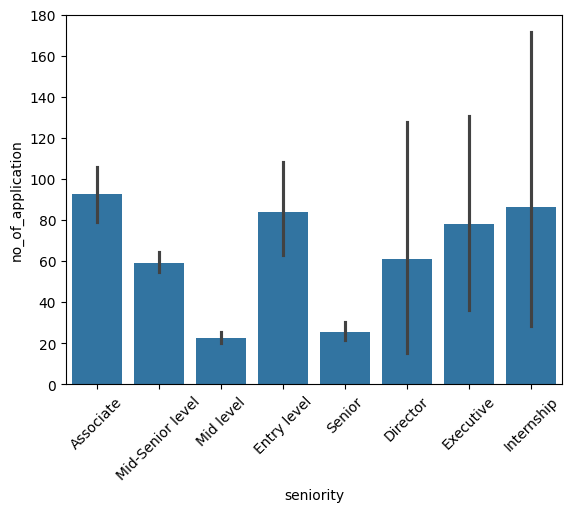

In [ ]:
sns.barplot(data=df, x="seniority", y="no_of_application")
plt.xticks(rotation=45);

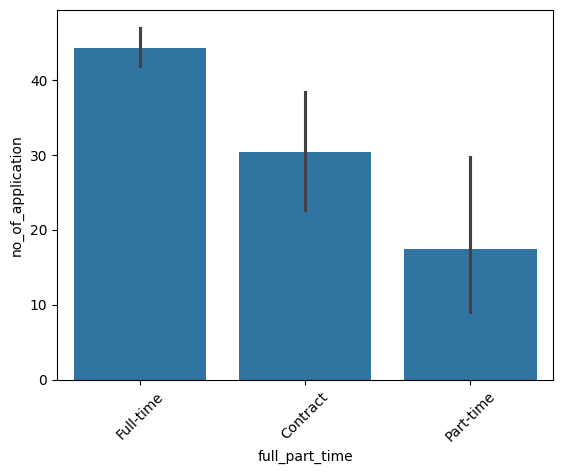

In [ ]:
sns.barplot(data=df, x="full_part_time", y="no_of_application")
plt.xticks(rotation=45);

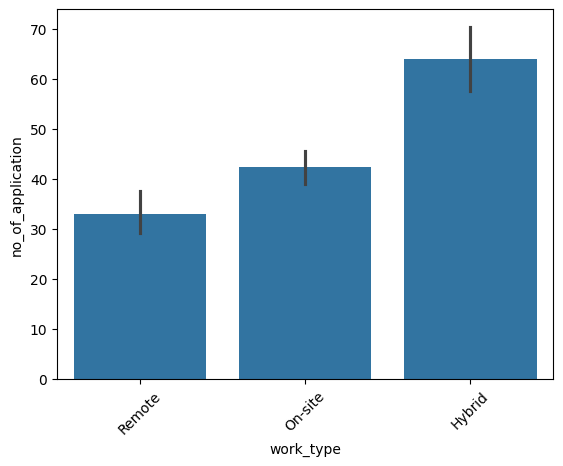

In [ ]:
sns.barplot(data=df, x="work_type", y="no_of_application")
plt.xticks(rotation=45);

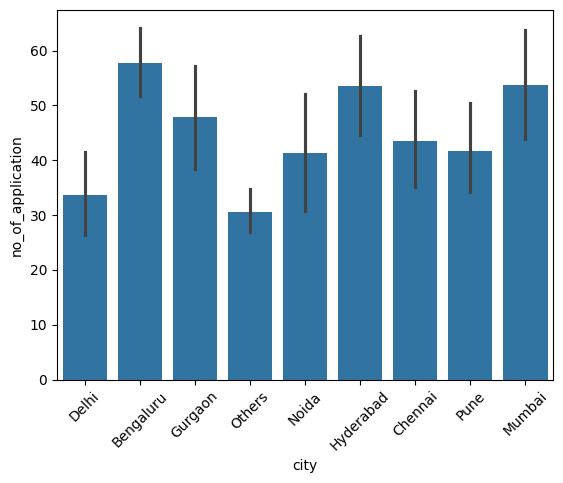

In [ ]:
sns.barplot(data=df, x="city", y="no_of_application")
plt.xticks(rotation=45);

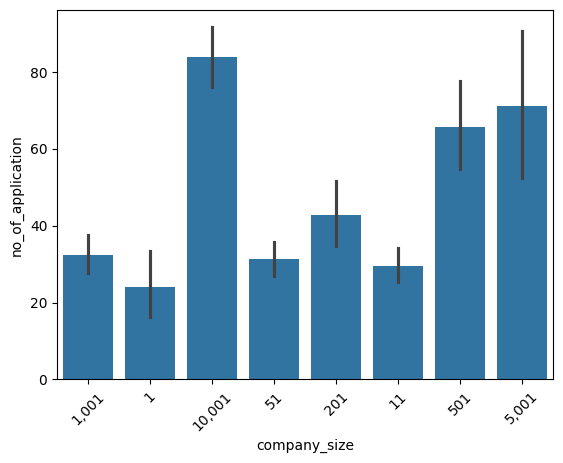

In [ ]:
sns.barplot(data=df, x="company_size", y="no_of_application")
plt.xticks(rotation=45);

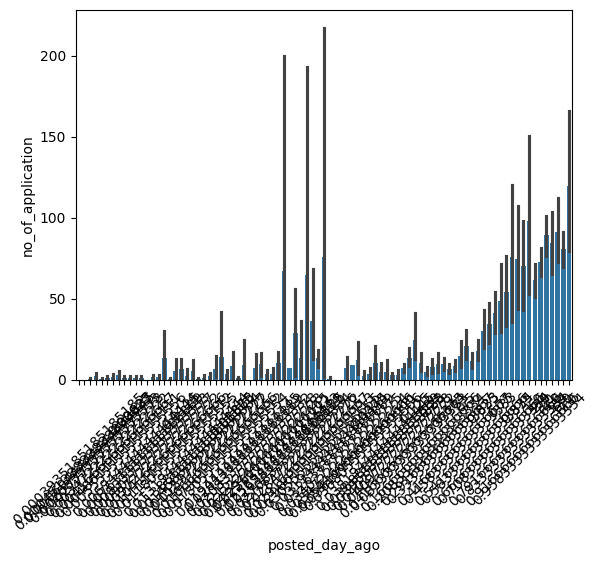

In [ ]:
sns.barplot(data=df, x="posted_day_ago", y="no_of_application")
plt.xticks(rotation=45);

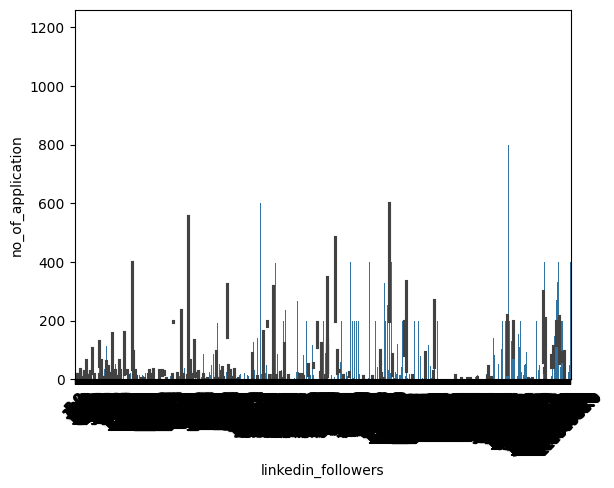

In [ ]:
sns.barplot(data=df, x="linkedin_followers", y="no_of_application")
plt.xticks(rotation=45);

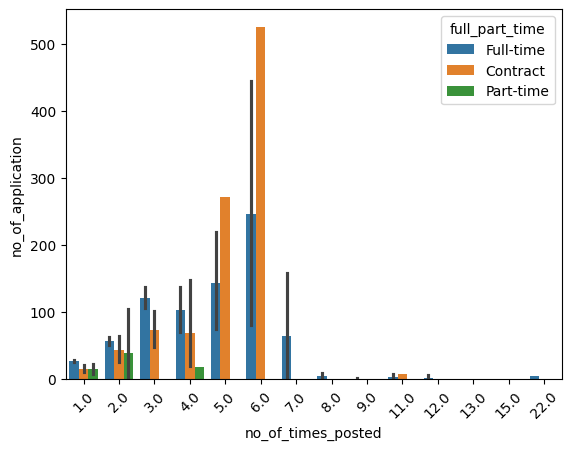

In [ ]:
sns.barplot(data=df, x="no_of_times_posted", y="no_of_application", hue="full_part_time")
plt.xticks(rotation=45);

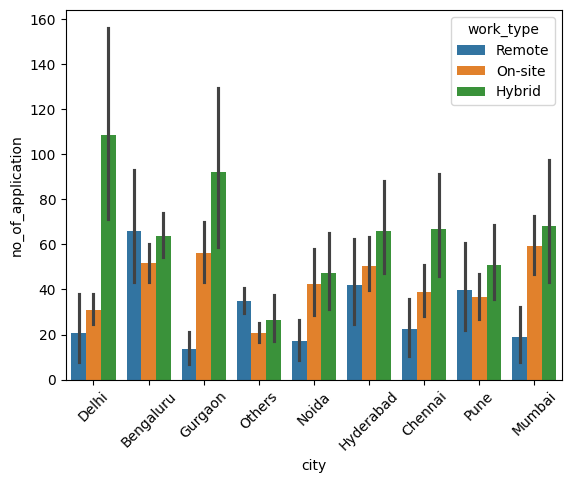

In [ ]:
sns.barplot(data=df, x="city", y="no_of_application", hue="work_type")
plt.xticks(rotation=45);

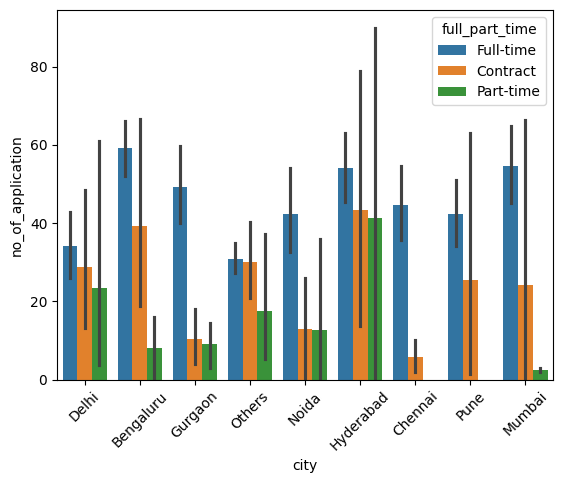

In [ ]:
sns.barplot(data=df, x="city", y="no_of_application", hue="full_part_time")
plt.xticks(rotation=45);

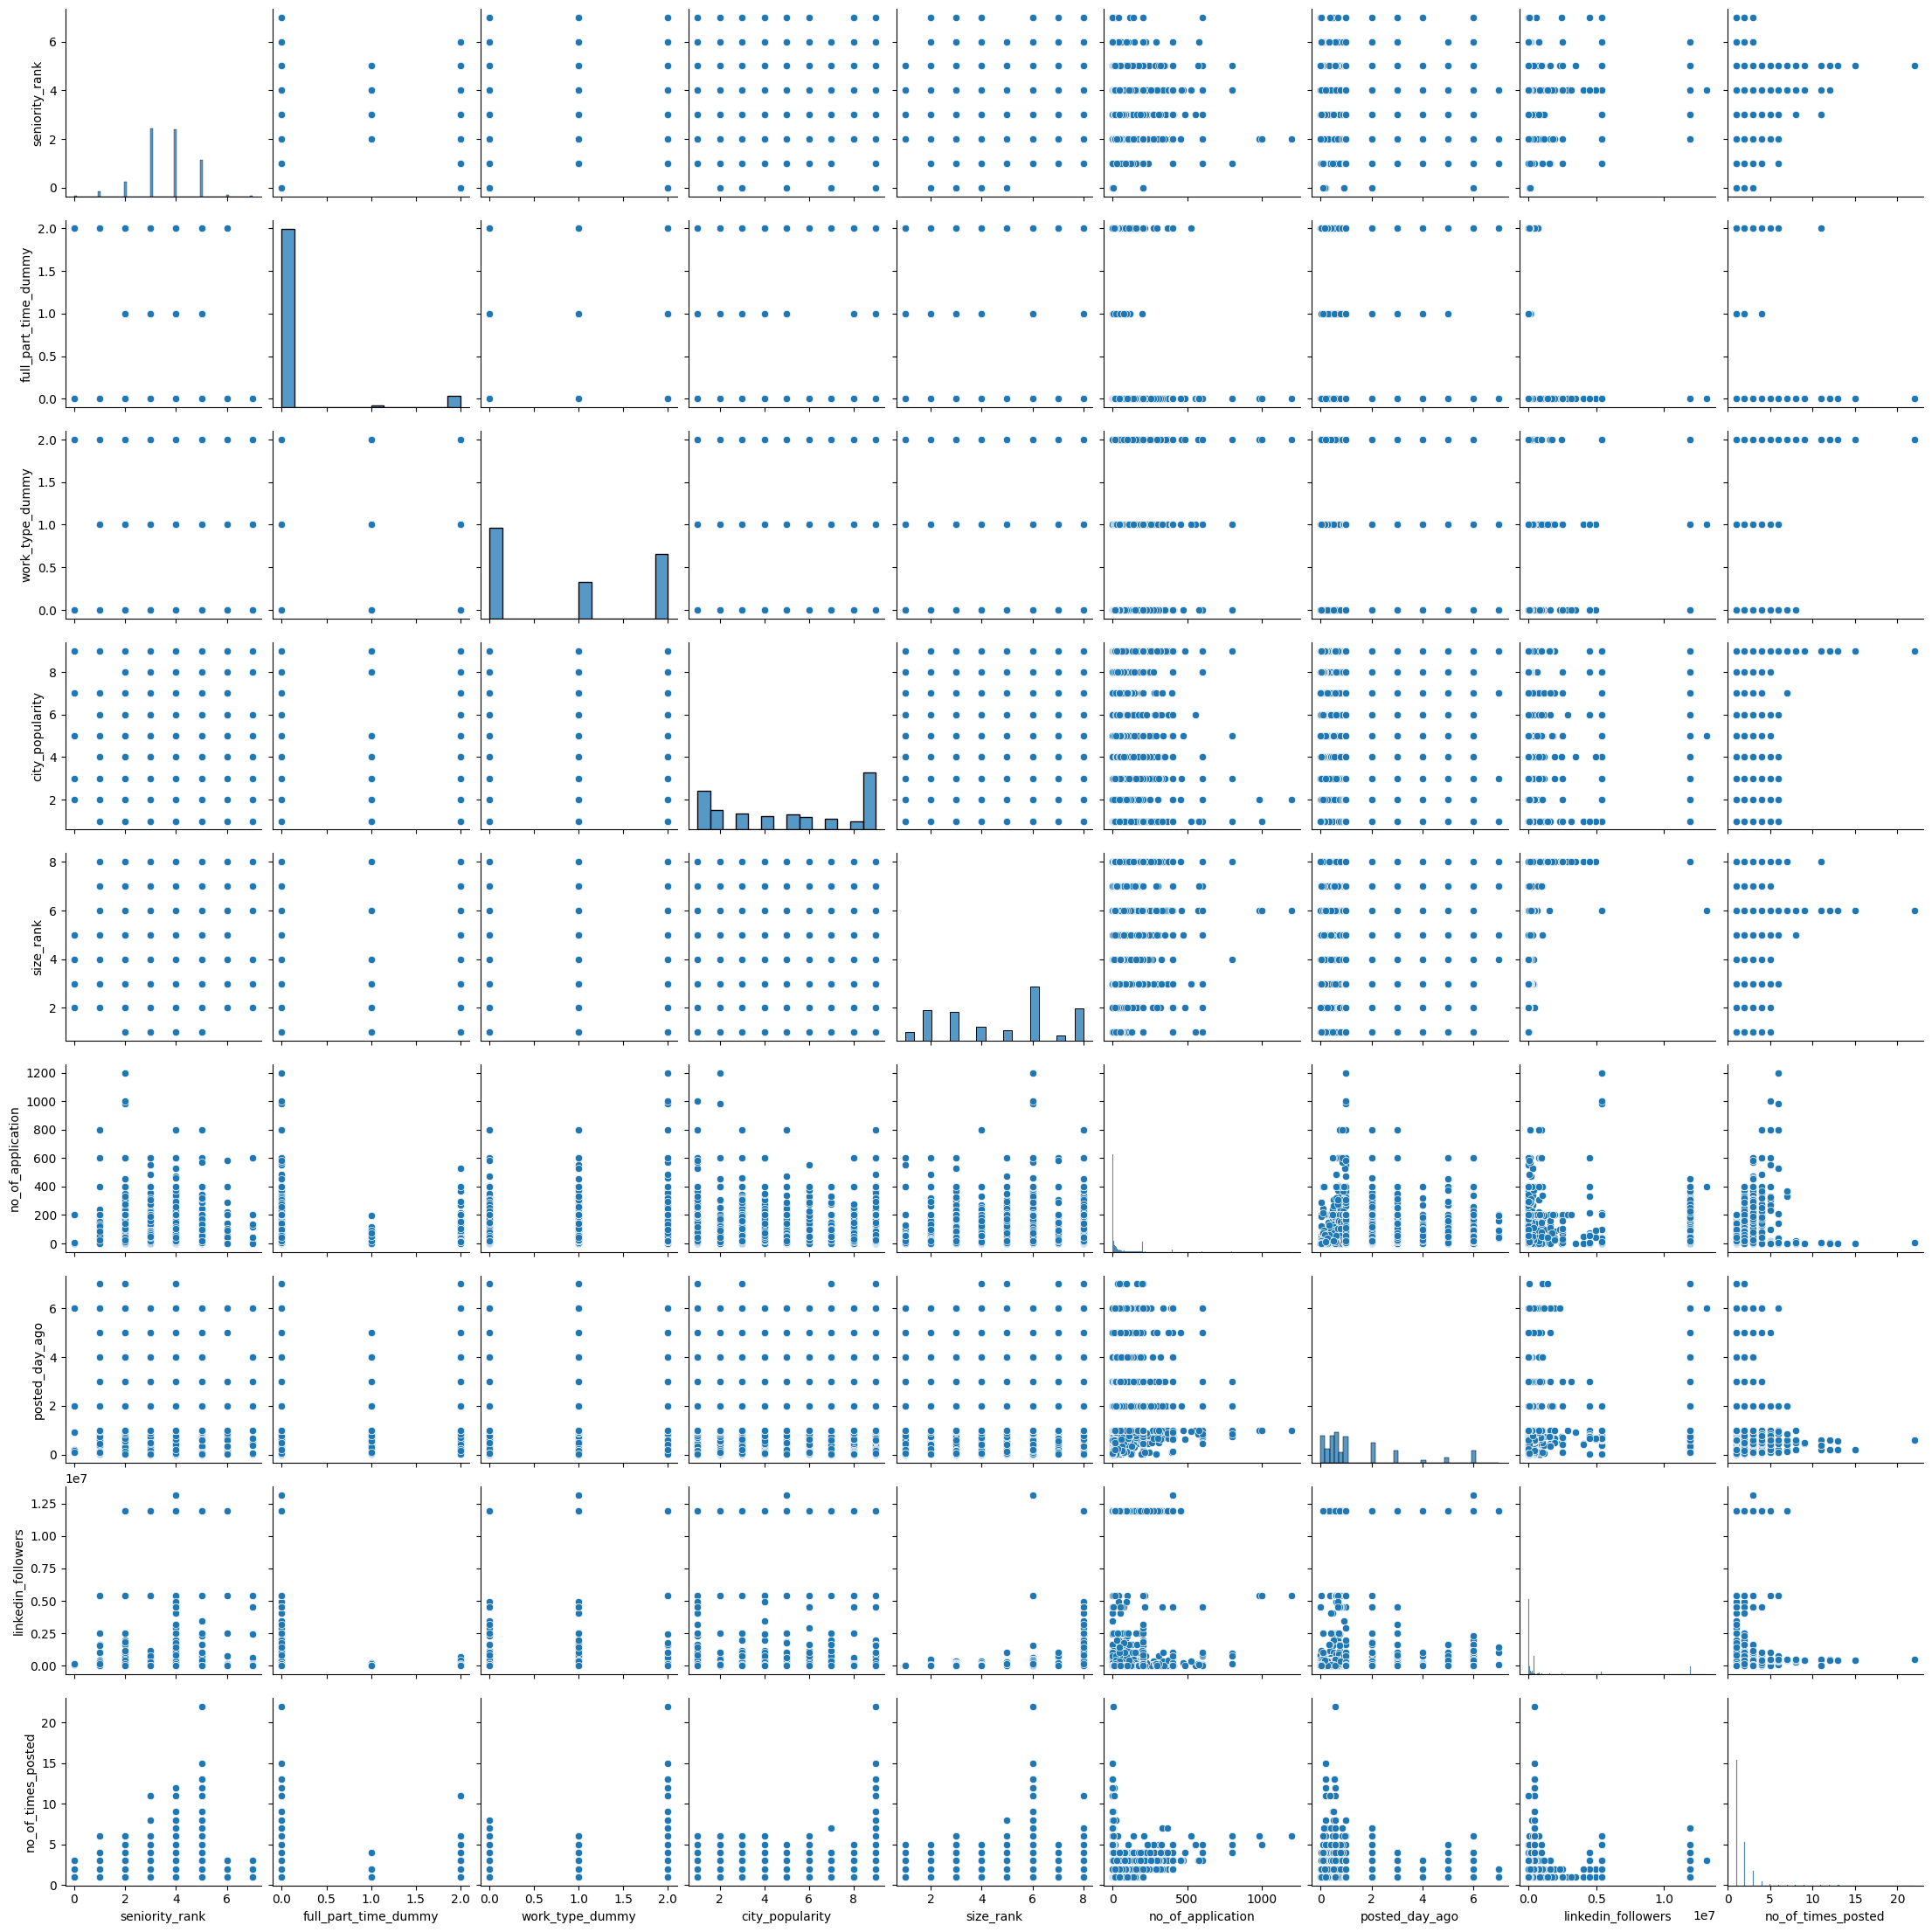

In [ ]:
sns.pairplot(df)

<ipython-input-183-aa4f4450a243>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

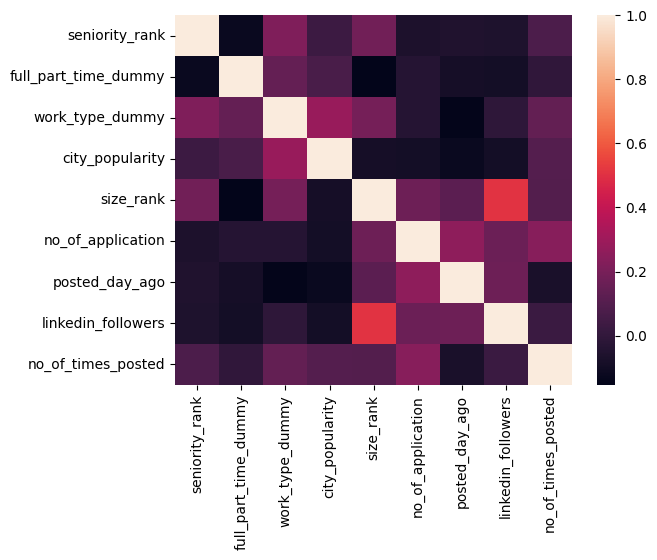

In [ ]:
sns.heatmap(df.corr())

In [ ]:
df.corr()

<ipython-input-184-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,seniority_rank,full_part_time_dummy,work_type_dummy,city_popularity,size_rank,no_of_application,posted_day_ago,linkedin_followers,no_of_times_posted
seniority_rank,1.000000,-0.125327,0.218851,0.027767,0.180415,-0.065466,-0.056646,-0.060745,0.076873
full_part_time_dummy,-0.125327,1.000000,0.147767,0.071343,-0.153312,-0.040068,-0.085833,-0.092300,-0.007425
work_type_dummy,0.218851,0.147767,1.000000,0.287961,0.189825,-0.037510,-0.148308,-0.012539,0.141946
city_popularity,0.027767,0.071343,0.287961,1.000000,-0.087888,-0.093041,-0.123670,-0.093741,0.101986
size_rank,0.180415,-0.153312,0.189825,-0.087888,1.000000,0.168004,0.118379,0.507210,0.094556
no_of_application,-0.065466,-0.040068,-0.037510,-0.093041,0.168004,1.000000,0.258818,0.162204,0.239016
posted_day_ago,-0.056646,-0.085833,-0.148308,-0.123670,0.118379,0.258818,1.000000,0.169231,-0.074580
linkedin_followers,-0.060745,-0.092300,-0.012539,-0.093741,0.507210,0.162204,0.169231,1.000000,0.024765
no_of_times_posted,0.076873,-0.007425,0.141946,0.101986,0.094556,0.239016,-0.074580,0.024765,1.000000


In [ ]:
from scipy.stats import pearsonr
pearsonr(df['no_of_application'], df['work_type_dummy'])

PearsonRResult(statistic=-0.037509587879338925, pvalue=0.007246349358118985)

In [ ]:
pearsonr(df['no_of_application'], df['full_part_time_dummy'])

PearsonRResult(statistic=-0.04006763539204096, pvalue=0.0041232096214286395)

<Axes: xlabel='work_type', ylabel='no_of_application'>

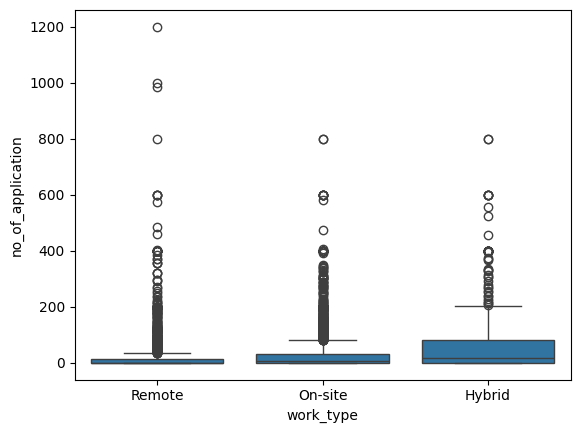

In [ ]:
sns.boxplot(x=df['work_type'], y=df['no_of_application'])

(array([1728.,    0.,    0.,    0.,    0., 2423.,    0.,    0.,    0.,
         973.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

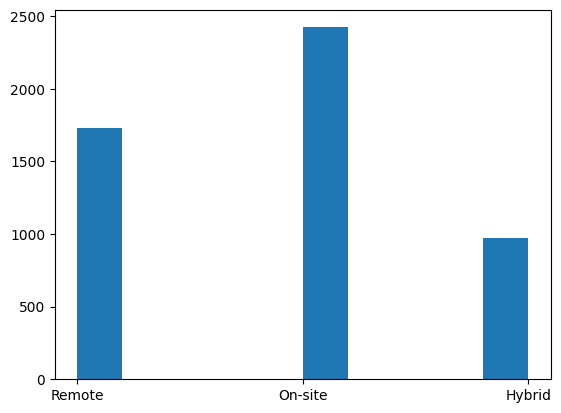

In [ ]:
plt.hist(df['work_type'])

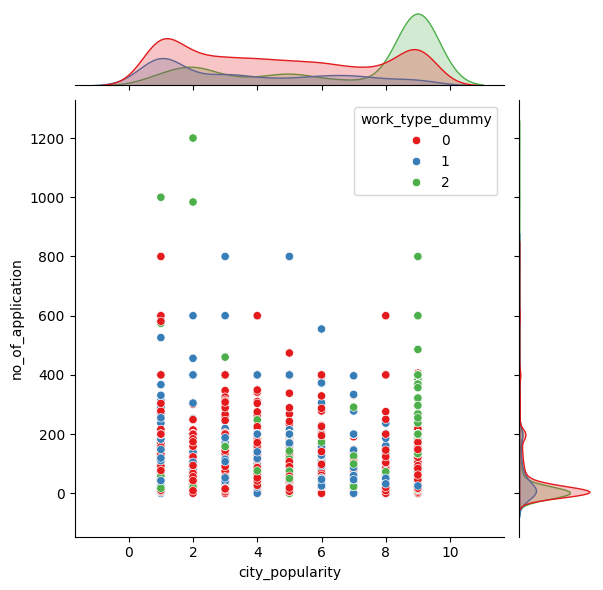

In [ ]:
sns.jointplot(x = 'city_popularity', y = 'no_of_application', hue = 'work_type_dummy', data = df, palette = 'Set1')

In [ ]:
newdf = df.loc[df['city_popularity']==1]

In [ ]:
pearsonr(newdf['no_of_application'], newdf['work_type_dummy'])

PearsonRResult(statistic=0.05467407198292241, pvalue=0.07916085277760905)

=> People in Delhi (PearsonRResult(statistic=0.05467407198292241, pvalue=0.07916085277760905)) and other big cities don't care of the job is remote/on-site. They just want a job. So it is not statistically significant. Although, more people apply to remote/hybrid jobs in the hope that they get a good deal. So there is a positive linear correlation, albeit small.

=> People in 'other' cities (PearsonRResult(statistic=0.08615685569381597, pvalue=0.0007510014284764181)), apply more to remote jobs so that they don't have to move. So the correlation is a lot more significant. And it is also a positive linear correlation.

In [ ]:
df.columns

Index(['job', 'job_details', 'company_name', 'seniority', 'seniority_rank',
       'full_part_time', 'full_part_time_dummy', 'work_type',
       'work_type_dummy', 'city', 'city_popularity', 'company_size',
       'size_rank', 'company_sector', 'no_of_application', 'posted_day_ago',
       'linkedin_followers', 'no_of_times_posted'],
      dtype='object')

In [ ]:
seniority/remoteness
seniority/location
pairplot